In [1]:
from collections import defaultdict, Counter
from tqdm import tqdm_notebook as tqdm
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sn
import nltk
from nltk.corpus import stopwords
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
main_df = pd.read_pickle('/content/drive/MyDrive/cs256/cs256_subreddit.pickle')
main_df

,id,subreddit,title,selftext,genre
0,6d8knd,talesfromtechsupport,remember your command line switches,"""hi there """,writing/stories
1,58mbft,teenmom,"""so what was matt """"addicted"""" to ? """,did he ever say what his addiction was or is h...,tv_show
2,8f73s7,Harley,no club colors,funny story i went to college in las vegas thi...,autos
3,6ti6re,ringdoorbell,not door bell but floodlight mount height,i know this is a sub for the 'ring doorbell' b...,hardware/tools
4,77sxto,intel,worried about my 8700k small fft/data stress r...,"""prime95 (regardless of version) and occt both...",electronics
...,...,...,...,...,...
1012995,5r9k4h,MSLGame,is this months rebirth and dungeon astro's wor...,i looking on what to evo3 farm next and was ex...,video_game
1012996,6529fp,CrohnsDisease,i might need a medical leave from grad school,has anyone here ever needed a medical leave fr...,health
1012997,7tiyzx,HongKong,police harassing ethnic minorities in hong kong,i thought i'd make this post so that more peop...,geo
1012998,664ha3,yorku,su eecs 2030 and eecs 2021 - need advice,hi i just finished 1st year eecs courses and h...,education


In [4]:
sampled_data = []
for genre in main_df['genre'].unique():
    genre_data = main_df[main_df['genre'] == genre].sample(n=3000, random_state=42)
    sampled_data.append(genre_data)

main_df_sampled = pd.concat(sampled_data)

# Shuffle the sampled data
main_df_sampled = main_df_sampled.sample(frac=1, random_state=42).reset_index(drop=True)

In [5]:
main_df_sampled.to_pickle('main_df_sampled.pickle')

In [6]:
genres = sorted(main_df_sampled['genre'].unique().tolist()) # this has to be sorted to match up with lstm model

print('Number of genres:', len(genres))

Number of genres: 39


In [7]:
# Get frequencies of each subreddit using efficient pandas filtering.
frequencies = defaultdict(int)
for genre in genres:
    frequencies[genre] = len(main_df_sampled.loc[main_df_sampled['genre'] == genre])

frequencies_df = pd.DataFrame([frequencies])
frequencies_df = frequencies_df.T

print(scipy.stats.describe(list(frequencies.values())))
print(frequencies_df)

DescribeResult(nobs=39, minmax=(3000, 3000), mean=3000.0, variance=0.0, skewness=nan, kurtosis=nan)
                          0
advice/question        3000
animals                3000
anime/manga            3000
appearance             3000
arts                   3000
autos                  3000
board_game             3000
books                  3000
card_game              3000
company/website        3000
crypto                 3000
drugs                  3000
education              3000
electronics            3000
finance/money          3000
food/drink             3000
geo                    3000
hardware/tools         3000
health                 3000
hobby                  3000
meta                   3000
movies                 3000
music                  3000
other                  3000
parenting              3000
politics/viewpoint     3000
profession             3000
programming            3000
religion/supernatural  3000
rpg                    3000
sex/relationships      3000
soci

<ipython-input-7-d6794b4f31c7>:9: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  print(scipy.stats.describe(list(frequencies.values())))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1405: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  sk = skew(a, axis, bias=bias)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1406: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt = kurtosis(a, axis, bias=bias)


In [9]:
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
import numpy as np
from sklearn import preprocessing
from tqdm import tqdm

# Tokenize text using simple_preprocess
preprocessed = [simple_preprocess(x) for x in tqdm(main_df_sampled['title'] + " " + main_df_sampled['selftext'])]

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=preprocessed, vector_size=300, window=5, min_count=1, workers=4)

def word_to_vec(word):
    if word not in word2vec_model.wv:
        return None
    return word2vec_model.wv[word]

def get_word2vec_embeddings(text):
    embeddings = [word_to_vec(word) for word in text if word in word2vec_model.wv]
    if len(embeddings) == 0:
        return None
    return np.mean(embeddings, axis=0)

100%|██████████| 117000/117000 [00:19<00:00, 6043.46it/s]


In [10]:
y = main_df_sampled['genre'].copy()

X_word2vec = []

for i, text in tqdm(enumerate(preprocessed)):
    embeddings = get_word2vec_embeddings(text)
    if embeddings is not None:
        X_word2vec.append(embeddings)
    else:
        del y[i]

117000it [00:32, 3615.71it/s]


In [11]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

y = label_encoder.fit_transform(y)

genre_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Genre Mapping:")
print(genre_mapping)

Genre Mapping:
{'advice/question': 0, 'animals': 1, 'anime/manga': 2, 'appearance': 3, 'arts': 4, 'autos': 5, 'board_game': 6, 'books': 7, 'card_game': 8, 'company/website': 9, 'crypto': 10, 'drugs': 11, 'education': 12, 'electronics': 13, 'finance/money': 14, 'food/drink': 15, 'geo': 16, 'hardware/tools': 17, 'health': 18, 'hobby': 19, 'meta': 20, 'movies': 21, 'music': 22, 'other': 23, 'parenting': 24, 'politics/viewpoint': 25, 'profession': 26, 'programming': 27, 'religion/supernatural': 28, 'rpg': 29, 'sex/relationships': 30, 'social_group': 31, 'software': 32, 'sports': 33, 'stem': 34, 'travel': 35, 'tv_show': 36, 'video_game': 37, 'writing/stories': 38}


In [12]:
X_word2vec_scaled = preprocessing.scale(X_word2vec)

In [13]:
X_word2vec_train, X_word2vec_test, y_word2vec_train, y_word2vec_test = train_test_split(X_word2vec_scaled, y, test_size=0.2, random_state=42)
print(X_word2vec_train.shape, X_word2vec_test.shape, y_word2vec_train.shape, y_word2vec_test.shape)

(93598, 300) (23400, 300) (93598,) (23400,)


In [14]:
y_word2vec_train

array([21,  9,  6, ..., 10,  4, 17])

## Random Forest Classifier with Word2Vec

In [29]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=10, random_state=0, n_estimators=400)
clf.fit(X_word2vec_train, y_word2vec_train)

RandomForestClassifier(max_depth=10, n_estimators=400, random_state=0)

In [33]:
rf_word2vec_predicted = clf.predict(X_word2vec_test)
rf_word2vec_proba = clf.predict_proba(X_word2vec_test)
print(rf_word2vec_proba)
print(rf_word2vec_predicted)

[[0.02401883 0.02935261 0.0146704  ... 0.01163825 0.02389155 0.01486476]
 [0.02025797 0.01238588 0.0116699  ... 0.00951195 0.02153862 0.01133226]
 [0.0324232  0.01949024 0.03244023 ... 0.03901993 0.02461012 0.02990118]
 ...
 [0.01911914 0.00313859 0.00583734 ... 0.00214818 0.01180843 0.00686139]
 [0.02737623 0.0189446  0.01469554 ... 0.0132699  0.02407613 0.02117463]
 [0.03035842 0.00542939 0.02260695 ... 0.01094273 0.04241572 0.01412897]]
[15 35  3 ... 27 34 27]


In [34]:
# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, normalize=False, title=None):
    data = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(data)
    if normalize:
        df_cm = df_cm.astype('float') / df_cm.sum(axis=1).values[:, np.newaxis]  # Convert DataFrame to numpy array here
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize=(10, 7))
    if title:
        plt.title(title)
    else:
        plt.title("Confusion Matrix")
    sn.set(font_scale=1.4)
    sn.heatmap(df_cm, cmap='Reds')


def output_metrics(y_true, y_pred, normalize_cm=False, title_cm=None):
  """Output metrics for a model:
    - accuracy
    - (normalized) confusion matrix
  """
  report = classification_report(y_true, y_pred, output_dict=True)
  macro_avg = report['macro avg']
  weighted_avg = report['weighted avg']

  print('Balanced Accuracy:', balanced_accuracy_score(y_true, y_pred))
  print('Accuracy:', report['accuracy'])
  print('\t\t precision\t\t recall\t\t\t f1-score\t\t support')
  print('Macro Avg: \t {}\t {}\t {}\t {}'.format(
      macro_avg['precision'], macro_avg['recall'], macro_avg['f1-score'], macro_avg['support']))
  print('Weighted Avg: \t {}\t {}\t {}\t {}'.format(
      weighted_avg['precision'], weighted_avg['recall'], weighted_avg['f1-score'], weighted_avg['support']))
  plot_confusion_matrix(y_true, y_pred, normalize=normalize_cm, title=title_cm)

Balanced Accuracy: 0.2723269383753183
Accuracy: 0.27145299145299145
		 precision		 recall			 f1-score		 support
Macro Avg: 	 0.25600020266964024	 0.2723269383753183	 0.22984056735210215	 23400
Weighted Avg: 	 0.25623381652050803	 0.27145299145299145	 0.22929481567828572	 23400


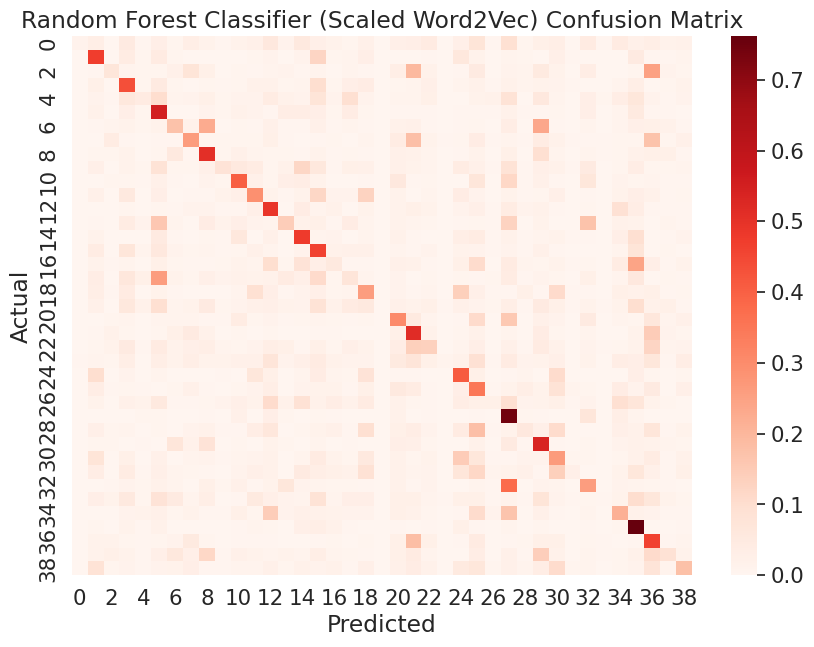

In [35]:
output_metrics(y_word2vec_test, rf_word2vec_predicted, normalize_cm=True, title_cm='Random Forest Classifier (Scaled Word2Vec) Confusion Matrix')